# Neural style transfer

This notebook is an assignment of fast.ai lesson8.
- http://forums.fast.ai/t/lesson-8-homework-assignments/1629

Neural Style Transfer is based on [this paper](https://arxiv.org/abs/1508.06576v2).

## Steps needed for Style Transfer using VGG:
### Content extraction

- Read the cont_image
- Resize cont_image
- Preprocess : RGB ->BGR and normalize
- Create VGG_avg
- Generate P(l) = activations for the cont_image at layer l
- Generate F(l) = activations for white noise image at layer l
- content_loss = MSE(P(l), F(l))

### Style extraction
- Read the style_image
- Resize style_image
- Preprocess : RGB ->BGR and normalize
- Create VGG_avg
- Generate Gram_matrix for original image, A(L) = Inner product of F * Ft for the layers L, where F is the vectorized feature map. (There is some weight to the loss for each layer?)
- Generate Gram_matrix for white noise image, G(L) similarly above
- style_loss = MSE(A(L), G(L))

### Style transfer
- loss(c,s,x) = a * content_loss(c, x) + b * style_loss(s, x), where c = content image, s = style image, x = generated image
- Use scipy's implementation of L-BFGS2 to find the values of "x" that minimize the loss (fmin_l_bfgs_b(loss, x0=x, args=(c, s))). In our case, "x" happens to be image pixels, and thus we end up searching for the image that is close to both the content image (c) and the style image (s).


## Setup
京都、嵐山の渡月橋。
- https://en.wikipedia.org/wiki/Arashiyama

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

In [4]:
path = '/home/ubuntu/cutting-edge-dl-for-coders-part2'

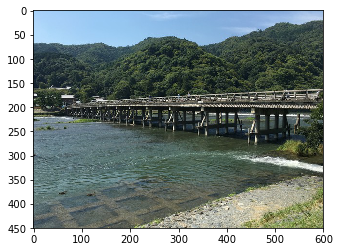

In [5]:
img=Image.open(path+'/data/bridge.jpg')
plt.imshow(np.array(img))

In [6]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [7]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [8]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

## Recreate Content 

In [9]:
model = VGG16_Avg(include_top=False)

In [10]:
layer = model.get_layer('block5_conv1').output

In [11]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [12]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [13]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [14]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

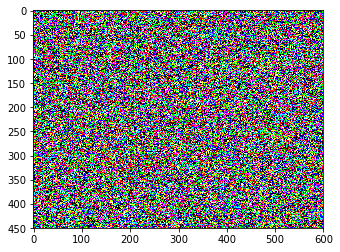

In [15]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [16]:
iterations=10

In [18]:
x = solve_image(evaluator, iterations, x)

Current loss value: 48.2291946411
Current loss value: 11.814458847
Current loss value: 6.15314722061
Current loss value: 4.10418081284
Current loss value: 3.15371417999
Current loss value: 2.62931346893
Current loss value: 2.59162425995
Current loss value: 2.59218120575
Current loss value: 2.59218072891
Current loss value: 2.59218072891


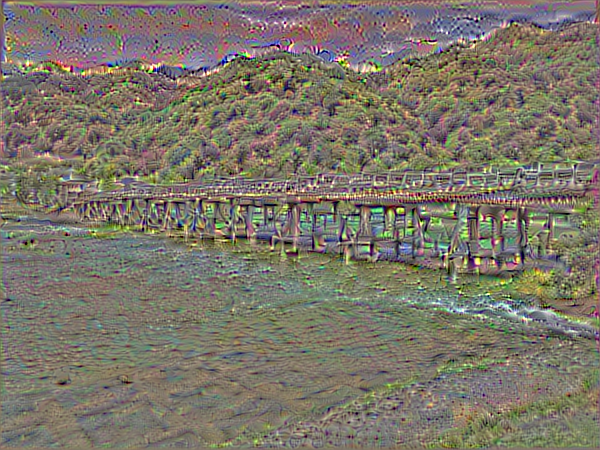

In [19]:
Image.open(path + '/results/res_at_iteration_9.png')

In [20]:
from IPython.display import HTML
from matplotlib import animation, rc

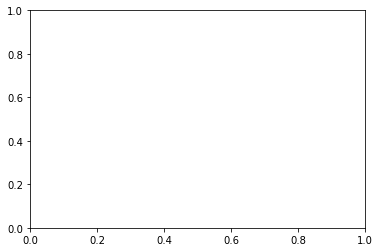

In [21]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}/results/res_at_iteration_{i}.png'))

In [22]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

## Recreate style

In [27]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [51]:
style = Image.open(path+'/data/starry_night.jpg')

In [52]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [53]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

In [54]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [55]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [56]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [57]:
def style_loss(x, targ):
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [58]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [59]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

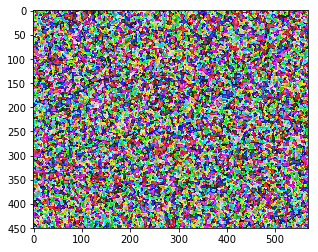

In [60]:
plt.imshow(x[0])

In [61]:
iterations=10
x = rand_img(shp)

In [62]:
x = solve_image(evaluator, iterations, x)

Current loss value: 2065.63867188
Current loss value: 196.682067871
Current loss value: 99.5655059814
Current loss value: 67.0934753418
Current loss value: 41.5264167786
Current loss value: 25.6243247986
Current loss value: 16.4236316681
Current loss value: 10.5170497894
Current loss value: 7.78677654266
Current loss value: 5.92503118515


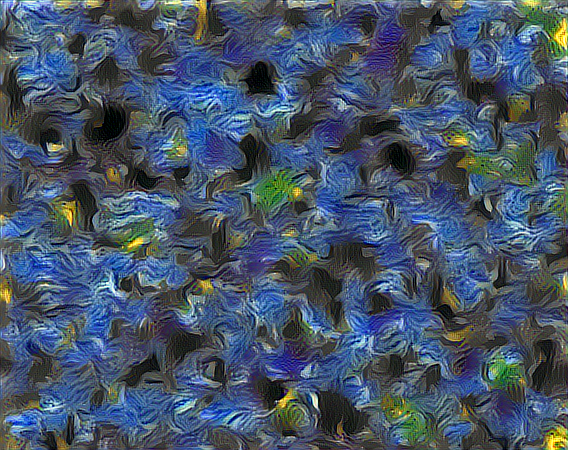

In [63]:
Image.open(path + '/results/res_at_iteration_9.png')

## Style transfer

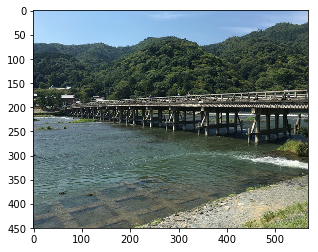

In [64]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

In [65]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [66]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [67]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [68]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [69]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [70]:
evaluator = Evaluator(transfer_fn, shp)

In [71]:
iterations=10
x = rand_img(shp)

In [72]:
x = solve_image(evaluator, iterations, x)

Current loss value: 2612.48999023
Current loss value: 639.54473877
Current loss value: 386.221099854
Current loss value: 292.773681641
Current loss value: 243.464904785
Current loss value: 209.745819092
Current loss value: 183.074325562
Current loss value: 163.345794678
Current loss value: 148.702102661
Current loss value: 136.507385254


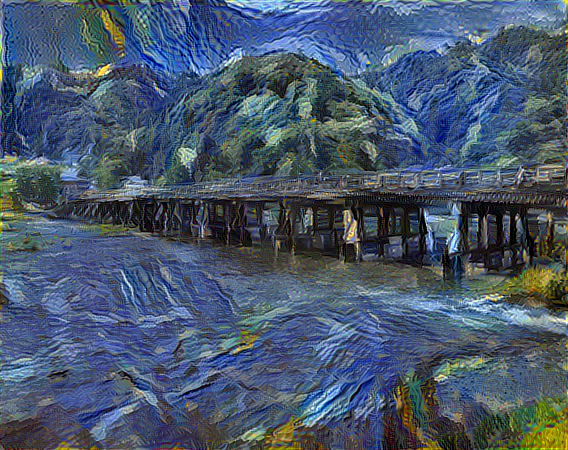

In [74]:
Image.open(path + '/results/res_at_iteration_9.png')